# Direct and Indirect Connectivity

This notebook builds on the previous notebook's FlyWire synaptic connectome graph dataset, considering how to normalize connectivity to align with our intuitions about functionally relevant synaptic partners. Those ideas will then be extended to estimat and compare indirect connectivity across longer paths in the graph.


## Setup


In [ ]:
# !pip3 install numpy pandas matplotlib seaborn igraph scipy pyarrow navis


In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import igraph
import numpy as np

# Pandas generates a lot of warnings with seaborn for current versions.
# These are harmless and sometimes pertinent, but create a lot of noise for our demonstrations.
# We can suppress them before we import pandas.
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)


DATA_DIR = Path(".").resolve().parent / "data"

Let's start by packaging the data loading we did in the previous notebook into something more convenient.


In [2]:
from dataclasses import dataclass


def simple_graph_plot(
    graph, fig=None, ax=None, vertex_label="name", edge_label="weight", **kwargs
):
    """Quick default plotting for `igraph.Graph`s."""
    if fig is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    elif ax is None:
        ax = fig.add_suplots(1, 1)

    if isinstance(vertex_label, str):
        vertex_label = graph.vs[vertex_label]
    if isinstance(edge_label, str):
        edge_label = graph.es[edge_label]

    plot_options = {"layout": "circle"} | kwargs

    igraph.plot(
        graph,
        target=ax,
        vertex_color="steelblue",
        vertex_label=vertex_label,
        edge_width=np.sqrt(edge_label),
        edge_label=edge_label,
        edge_color="#666",
        edge_align_label=True,
        edge_background="white",
        **plot_options,
    )

    return fig, ax


@dataclass
class FlyWireGraph:
    edges: pd.DataFrame
    annot: pd.DataFrame
    graph: igraph.Graph

    def __init__(self):
        self.edges = pd.read_feather(
            DATA_DIR / "syn_proof_analysis_filtered_630.feather"
        )
        self.annot = pd.read_csv(
            DATA_DIR / "Supplemental_file1_annotations.tsv", sep="\t"
        ).set_index("root_id")
        self.annot["merged_type"] = self.annot.cell_type.fillna(
            self.annot.hemibrain_type
        )
        self.graph = igraph.Graph.DataFrame(
            self.edges, directed=True, use_vids=False)

    def plot_edges_subgraph(
        self,
        edges,
        fig=None,
        ax=None,
        vertex_label="merged_type",
        edge_label="syn_count",
    ):
        path_graph = self.graph.subgraph_edges(edges)
        layout = path_graph.layout("tree")
        layout.rotate(-90.0)

        return simple_graph_plot(
            path_graph,
            fig=fig,
            ax=ax,
            layout=layout,
            vertex_label=self.annot.loc[path_graph.vs["name"]][vertex_label],
            edge_label=edge_label,
        )


In [3]:
fw = FlyWireGraph()

/var/folders/rf/8cfvv8zn689czv361jw9prvd1s1jvg/T/ipykernel_39321/3935303458.py:46: DtypeWarning: Columns (14,15,16,17,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  self.annot = pd.read_csv(


Picking up where we left off, we reproduce the shortest path from our arbitrary neuron of interest to all DNs, with its unsatisfying results:


In [4]:
voi = fw.graph.vs.find(name_eq=720575940604787424)

dns = fw.annot.loc[fw.annot.cell_class == "DN"]
dns_vs = fw.graph.vs.select(name_in=dns.index)

dn_paths = fw.graph.get_shortest_paths(voi, to=dns_vs, output="epath")


(<Figure size 600x600 with 1 Axes>, <Axes: >)

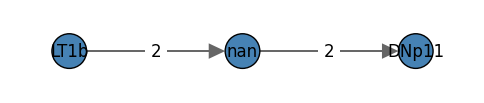

In [5]:
fw.plot_edges_subgraph(dn_paths[0])


(<Figure size 600x600 with 1 Axes>, <Axes: >)

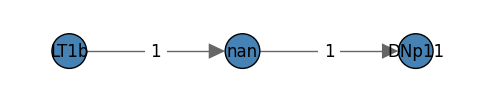

In [6]:
dn_paths_syn_count = fw.graph.get_shortest_paths(
    voi, to=dns_vs, output="epath", weights="syn_count"
)
fw.plot_edges_subgraph(dn_paths_syn_count[0])

## Normalizing Synaptic Edges


(<Figure size 600x600 with 1 Axes>, <Axes: >)

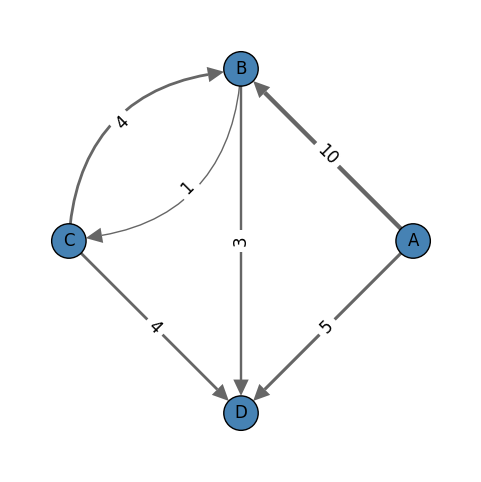

In [7]:
toy_adj = np.asarray(
    [
        [0, 10, 0, 5],
        [0, 0, 1, 3],
        [0, 4, 0, 4],
        [0, 0, 0, 0],
    ],
)
toy_graph = igraph.Graph.Adjacency(toy_adj > 0)
toy_graph.vs["name"] = ["A", "B", "C", "D"]
toy_graph.es["weight"] = toy_adj[toy_adj.nonzero()]
simple_graph_plot(toy_graph)


### Input Normalization


In [8]:
toy_total_inputs = np.sum(toy_adj, axis=0)
toy_total_inputs[toy_total_inputs == 0] = 1
toy_adj_inorm = toy_adj / toy_total_inputs
toy_adj_inorm

array([[0.        , 0.71428571, 0.        , 0.41666667],
       [0.        , 0.        , 1.        , 0.25      ],
       [0.        , 0.28571429, 0.        , 0.33333333],
       [0.        , 0.        , 0.        , 0.        ]])

(<Figure size 600x600 with 1 Axes>, <Axes: >)

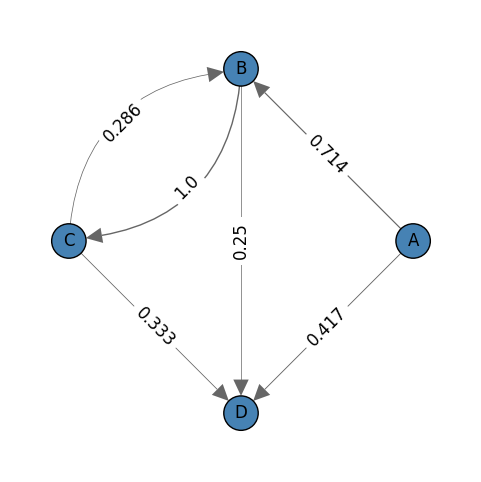

In [9]:
toy_graph.es["inorm"] = toy_adj_inorm[toy_adj.nonzero()]
simple_graph_plot(toy_graph, edge_label=np.round(toy_graph.es["inorm"], 3))


In [10]:
fw.edges["syn_inorm"] = fw.edges.syn_count / fw.edges.groupby(
    "post_pt_root_id"
).syn_count.transform("sum")
fw.edges.head()

,pre_pt_root_id,post_pt_root_id,syn_count,syn_inorm
0,720575940596125868,720575940605825666,2,0.003766
1,720575940596125868,720575940606217138,1,0.001294
2,720575940596125868,720575940608552405,5,0.002933
3,720575940596125868,720575940609975854,4,0.004219
4,720575940596125868,720575940611348834,7,0.001147


In [11]:
fw.graph.es["syn_inorm"] = fw.edges.syn_inorm.values
fw.graph.es[0]


igraph.Edge(<igraph.Graph object at 0x1437dcf50>, 0, {'syn_count': 2, 'syn_inorm': 0.003766478342749529})

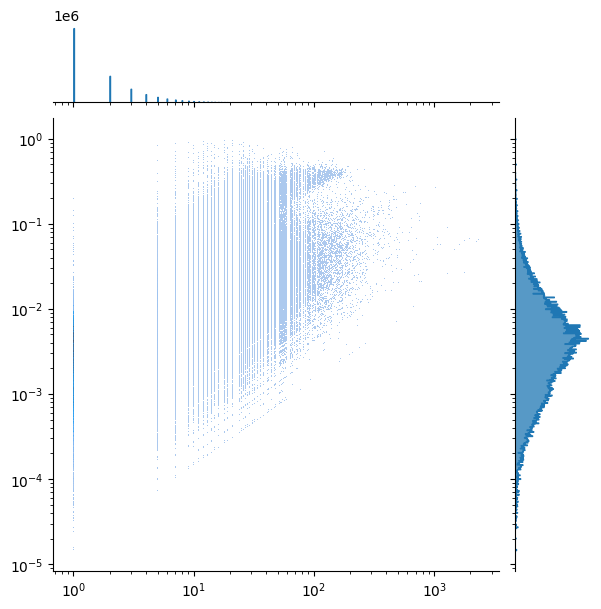

In [12]:
sns.jointplot(
    # data=fw.graph.es,
    x=fw.graph.es["syn_count"],
    y=fw.graph.es["syn_inorm"],
    kind="hist",
    marginal_kws={"element": "step"},
    log_scale=True,
)


### Output Normalization


In [13]:
toy_total_outputs = np.sum(toy_adj, axis=1, keepdims=True)
toy_total_outputs[toy_total_outputs == 0] = 1
toy_adj_onorm = toy_adj / toy_total_outputs
toy_adj_onorm

array([[0.        , 0.66666667, 0.        , 0.33333333],
       [0.        , 0.        , 0.25      , 0.75      ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.        , 0.        ]])

(<Figure size 600x600 with 1 Axes>, <Axes: >)

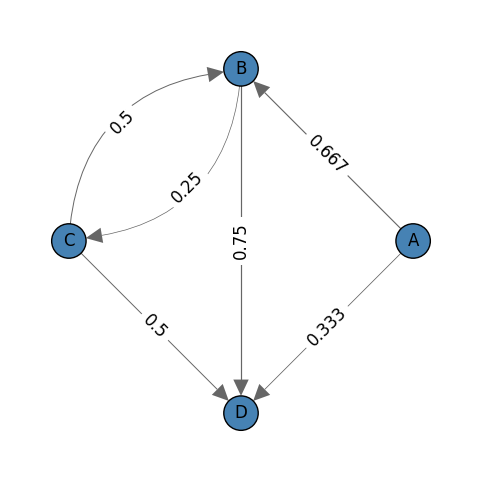

In [14]:
toy_graph.es["onorm"] = toy_adj_onorm[toy_adj.nonzero()]
simple_graph_plot(toy_graph, edge_label=np.round(toy_graph.es["onorm"], 3))


In [15]:
fw.edges["syn_onorm"] = fw.edges.syn_count / fw.edges.groupby(
    "pre_pt_root_id"
).syn_count.transform("sum")
fw.edges.head()

,pre_pt_root_id,post_pt_root_id,syn_count,syn_inorm,syn_onorm
0,720575940596125868,720575940605825666,2,0.003766,0.011050
1,720575940596125868,720575940606217138,1,0.001294,0.005525
2,720575940596125868,720575940608552405,5,0.002933,0.027624
3,720575940596125868,720575940609975854,4,0.004219,0.022099
4,720575940596125868,720575940611348834,7,0.001147,0.038674


In [16]:
fw.graph.es["syn_onorm"] = fw.edges.syn_onorm.values
fw.graph.es[0]


igraph.Edge(<igraph.Graph object at 0x1437dcf50>, 0, {'syn_count': 2, 'syn_inorm': 0.003766478342749529, 'syn_onorm': 0.011049723756906077})

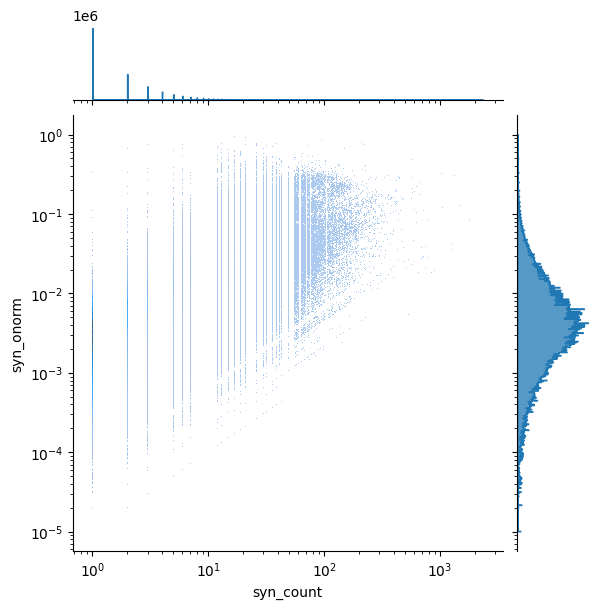

In [17]:
sns.jointplot(
    data=fw.edges,
    x="syn_count",
    y="syn_onorm",
    kind="hist",
    marginal_kws={"element": "step"},
    log_scale=True,
)


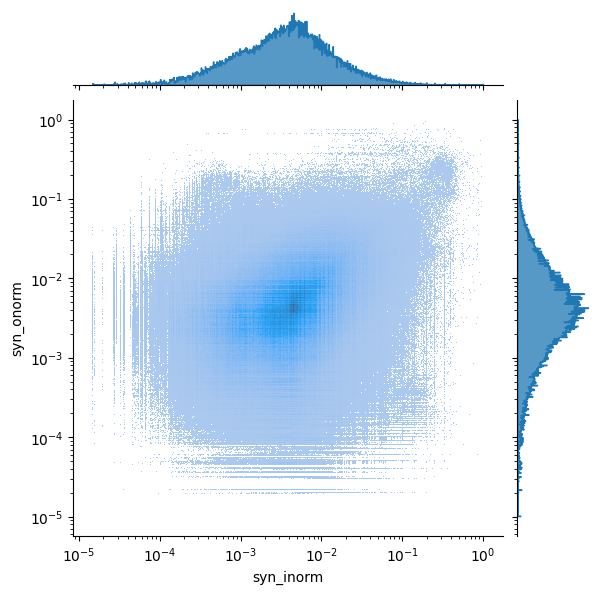

In [18]:
sns.jointplot(
    data=fw.edges,
    x="syn_inorm",
    y="syn_onorm",
    kind="hist",
    marginal_kws={"element": "step"},
    log_scale=True,
)


### Mean Proportion Normalization


In [19]:
toy_adj_norm_artmean = (toy_adj_inorm + toy_adj_onorm) / 2.0


(<Figure size 600x600 with 1 Axes>, <Axes: >)

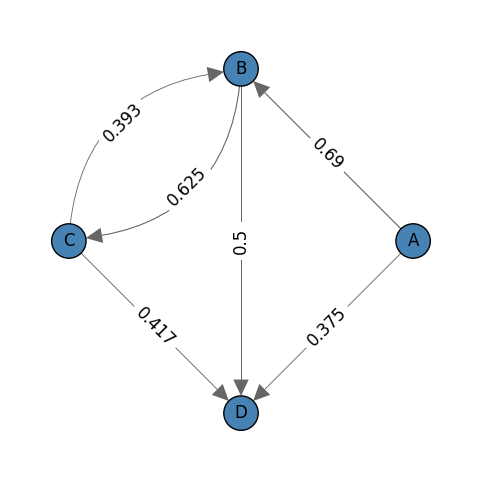

In [20]:
toy_graph.es["norm_artmean"] = toy_adj_norm_artmean[toy_adj.nonzero()]
simple_graph_plot(toy_graph, edge_label=np.round(
    toy_graph.es["norm_artmean"], 3))


In [21]:
fw.edges["syn_norm_artmean"] = (fw.edges.syn_onorm + fw.edges.syn_inorm) / 2.0
fw.graph.es["syn_norm_artmean"] = fw.edges.syn_norm_artmean.values


In [22]:
toy_adj_norm_geomean = np.sqrt(toy_adj_inorm * toy_adj_onorm)


(<Figure size 600x600 with 1 Axes>, <Axes: >)

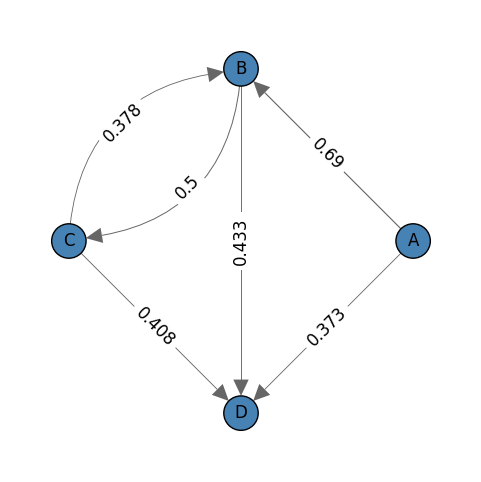

In [23]:
toy_graph.es["norm_geomean"] = toy_adj_norm_geomean[toy_adj.nonzero()]
simple_graph_plot(toy_graph, edge_label=np.round(
    toy_graph.es["norm_geomean"], 3))


In [24]:
fw.edges["syn_norm_geomean"] = np.sqrt(
    fw.edges.syn_onorm.values * fw.edges.syn_inorm.values
)
fw.graph.es["syn_norm_geomean"] = fw.edges.syn_norm_geomean.values

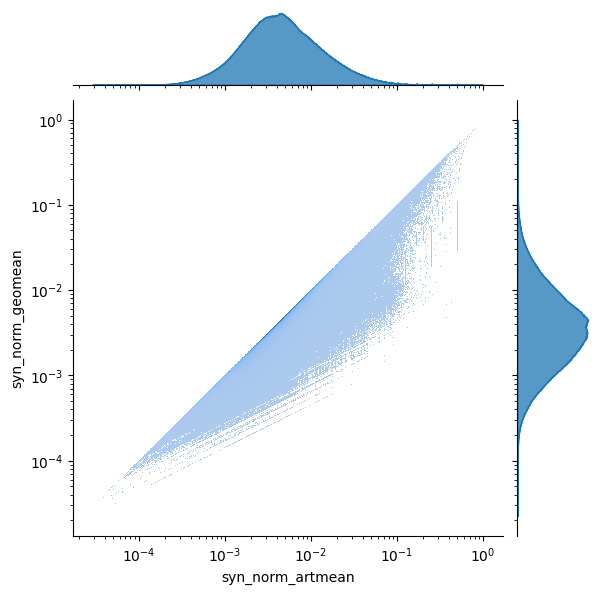

In [25]:
sns.jointplot(
    data=fw.edges,
    x="syn_norm_artmean",
    y="syn_norm_geomean",
    kind="hist",
    marginal_kws={"element": "step"},
    log_scale=True,
)


### Rank Normalization


In [26]:
import scipy.stats

toy_rank_inorm = scipy.stats.rankdata(-toy_adj, axis=0)
toy_rank_inorm

array([[2.5, 1. , 3. , 1. ],
       [2.5, 3.5, 1. , 3. ],
       [2.5, 2. , 3. , 2. ],
       [2.5, 3.5, 3. , 4. ]])

(<Figure size 600x600 with 1 Axes>, <Axes: >)

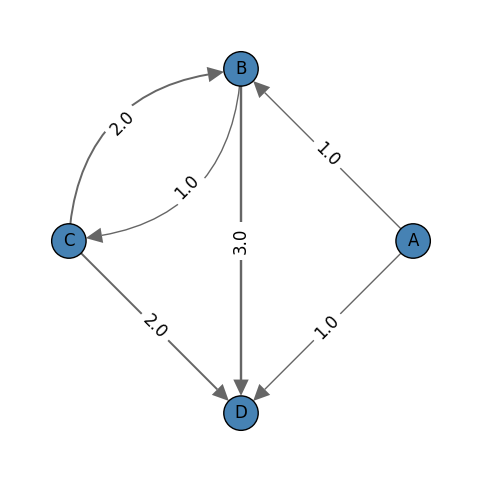

In [27]:
toy_graph.es["rank_inorm"] = toy_rank_inorm[toy_adj.nonzero()]
simple_graph_plot(toy_graph, edge_label=np.round(
    toy_graph.es["rank_inorm"], 3))


In [28]:
fw.edges["syn_rank_inorm"] = fw.edges.groupby("post_pt_root_id").syn_count.rank(
    ascending=False
)
fw.graph.es["syn_rank_inorm"] = fw.edges.syn_rank_inorm.values

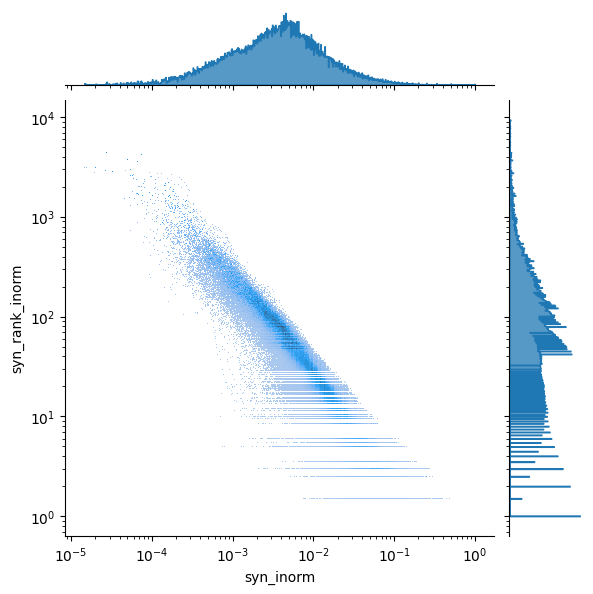

In [29]:
sns.jointplot(
    data=fw.edges,
    x="syn_inorm",
    y="syn_rank_inorm",
    kind="hist",
    marginal_kws={"element": "step"},
    log_scale=True,
)


### Revisiting Shortest Paths


(<Figure size 600x600 with 1 Axes>, <Axes: >)

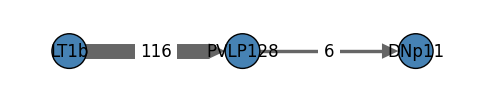

In [30]:
dn_paths_syn_inorm = fw.graph.get_shortest_paths(
    voi, to=dns_vs, output="epath", weights=1 - np.asarray(fw.graph.es["syn_inorm"])
)
fw.plot_edges_subgraph(dn_paths_syn_inorm[0])

(<Figure size 600x600 with 1 Axes>, <Axes: >)

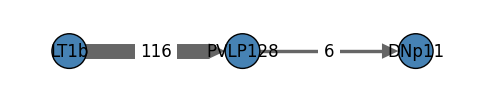

In [31]:
dn_paths_syn_onorm = fw.graph.get_shortest_paths(
    voi, to=dns_vs, output="epath", weights=1 - np.asarray(fw.graph.es["syn_onorm"])
)
fw.plot_edges_subgraph(dn_paths_syn_onorm[0])

In [32]:
dns_by_size = pd.merge(
    dns,
    fw.edges.groupby("post_pt_root_id").syn_count.sum(),
    left_index=True,
    right_index=True,
).sort_values(by="syn_count", ascending=False)
dns_by_size.head(20)[["merged_type", "syn_count"]]


,merged_type,syn_count
720575940620918789,DNa03,13740
720575940604737708,DNa02,13160
720575940623781127,DNpe095,13122
720575940610505006,DNpe095,13086
720575940629461442,DNb05,12830
720575940630085583,DNa03,12580
720575940629327659,DNa02,12263
720575940620266689,DNb05,12060
720575940612603289,DNge211,12057
720575940618574749,DNg35,11648


In [33]:
dns_by_size.loc[dns_vs[0]["name"], ["merged_type", "syn_count"]]

merged_type    DNp11
syn_count       3740
Name: 720575940629777018, dtype: object

(<Figure size 600x600 with 1 Axes>, <Axes: >)

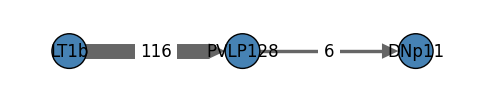

In [34]:
dn_paths_syn_artmean = fw.graph.get_shortest_paths(
    voi,
    to=dns_vs,
    output="epath",
    weights=1.0 - np.asarray(fw.graph.es["syn_norm_artmean"]),
)
fw.plot_edges_subgraph(dn_paths_syn_artmean[0])


(<Figure size 600x600 with 1 Axes>, <Axes: >)

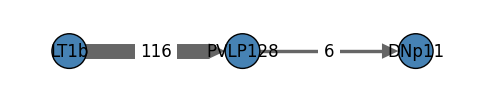

In [35]:
dn_paths_syn_geomean = fw.graph.get_shortest_paths(
    voi,
    to=dns_vs,
    output="epath",
    weights=1.0 - np.asarray(fw.graph.es["syn_norm_geomean"]),
)
fw.plot_edges_subgraph(dn_paths_syn_geomean[0])


(<Figure size 1200x300 with 1 Axes>, <Axes: >)

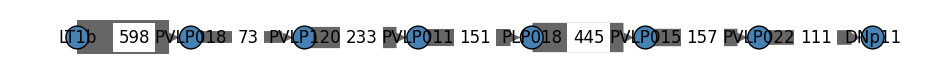

In [36]:
dn_paths_syn_irank = fw.graph.get_shortest_paths(
    voi, to=dns_vs, output="epath", weights=np.asarray(fw.graph.es["syn_rank_inorm"])
)
fig, ax = plt.subplots(figsize=(12, 3))
fw.plot_edges_subgraph(dn_paths_syn_irank[0], fig=fig, ax=ax)

(<Figure size 1200x300 with 1 Axes>, <Axes: >)

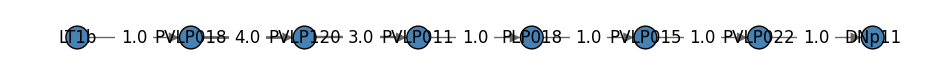

In [37]:
fig, ax = plt.subplots(figsize=(12, 3))
fw.plot_edges_subgraph(
    dn_paths_syn_irank[0], fig=fig, ax=ax, edge_label="syn_rank_inorm"
)


(<Figure size 1200x300 with 1 Axes>, <Axes: >)

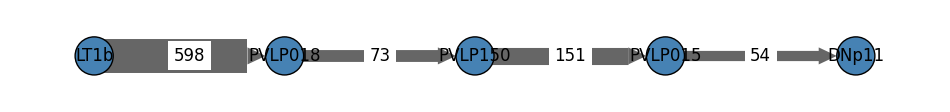

In [38]:
dn_paths_syn_irank_sqrt = fw.graph.get_shortest_paths(
    voi, to=dns_vs, output="epath", weights=np.sqrt(fw.graph.es["syn_rank_inorm"])
)
fig, ax = plt.subplots(figsize=(12, 3))
fw.plot_edges_subgraph(dn_paths_syn_irank_sqrt[0], fig=fig, ax=ax)

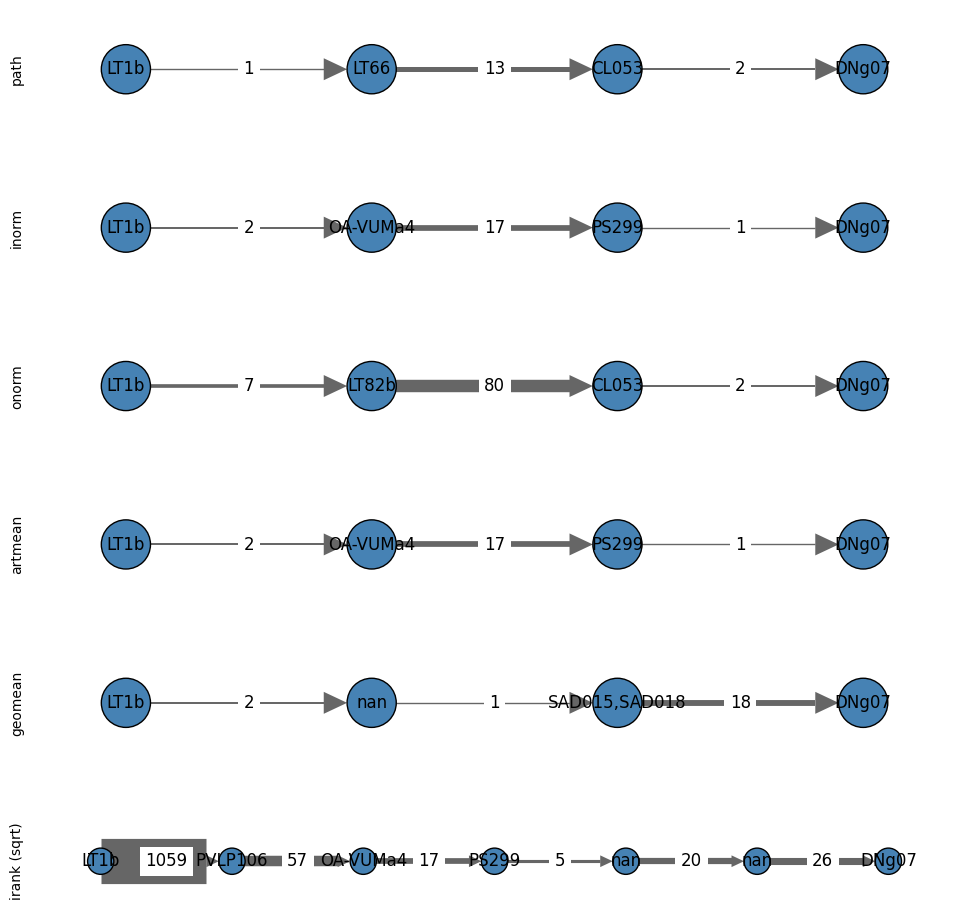

In [39]:
dn_idx = 1000

norm_paths = [
    ("path", dn_paths),
    ("inorm", dn_paths_syn_inorm),
    ("onorm", dn_paths_syn_onorm),
    ("artmean", dn_paths_syn_artmean),
    ("geomean", dn_paths_syn_geomean),
    ("irank (sqrt)", dn_paths_syn_irank_sqrt),
]
fig, axs = plt.subplots(len(norm_paths), 1, figsize=(12, len(norm_paths) * 2))

for i, (norm, g) in enumerate(norm_paths):
    fw.plot_edges_subgraph(g[dn_idx], fig=fig, ax=axs[i])
    axs[i].set_ylabel(norm)


### What Didn't We Consider

- Degree normalization (see Lin, _et al._)
- Signed weights
- Neurotransmitter composition
- Type-to-type normalization
- **Thresholding**


## Indirect Connectivity


### Building Intuition: How ~~Not~~ to Find Shortest Paths


(<Figure size 600x600 with 1 Axes>, <Axes: >)

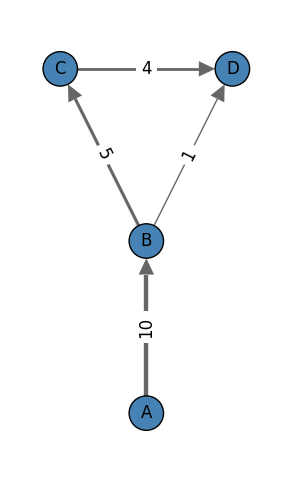

In [40]:
toy2_adj = np.asarray(
    [
        [0, 10, 0, 0],
        [0, 0, 5, 1],
        [0, 0, 0, 4],
        [0, 0, 0, 0],
    ],
)
toy2_graph = igraph.Graph.Adjacency(toy2_adj > 0)
toy2_graph.vs["name"] = ["A", "B", "C", "D"]
toy2_graph.es["weight"] = toy2_adj[toy2_adj.nonzero()]
simple_graph_plot(toy2_graph, layout="tree")


### Dot Product Propagation


In [41]:
import copy

al = copy.copy(fw)
al.annot = al.annot.loc[
    al.annot.cell_class.str.startswith(
        "AL"
    )  # Keep all antennal lobe local & projection neurons
    | (
        (al.annot.super_class == "sensory") & (
            al.annot.cell_class == "olfactory")
    )  # keep olfactory sensory
]
al.annot = al.annot[al.annot.side == "left"]
len(al.annot)


1690

In [69]:
al.edges = al.edges[
    al.edges.pre_pt_root_id.isin(al.annot.index)
    & al.edges.post_pt_root_id.isin(al.annot.index)
]

# Let's also drop weak edges (speeds up the simulation)
# al.edges = al.edges[al.edges.syn_count > 3]

al.edges = al.edges.copy()

len(al.edges)


28550

In [43]:
al.graph = igraph.Graph.DataFrame(al.edges, directed=True, use_vids=False)


In [44]:
n_al_neurons = len(al.annot)
pre_loc = al.annot.index.get_indexer(al.edges.iloc[:, 0].to_numpy())
post_loc = al.annot.index.get_indexer(al.edges.iloc[:, 1].to_numpy())
al_adj_sp = scipy.sparse.coo_array(
    (al.edges.iloc[:, 2].to_numpy(), np.stack([pre_loc, post_loc], axis=0)),
    shape=(n_al_neurons, n_al_neurons),
)
al_adj = al_adj_sp.todense()
al_adj.shape

(1690, 1690)

In [46]:
al_sensory_ind = (al.annot.super_class == "sensory") & (
    al.annot.cell_class == "olfactory"
)
al_sensory_ind[:10]

root_id
720575940625586122    False
720575940659400577    False
720575940612468594    False
720575940610773782    False
720575940622368792    False
720575940628181520    False
720575940619895125    False
720575940625784153    False
720575940641773472    False
720575940634333631    False
dtype: bool

In [47]:
n_sensories = al_sensory_ind.sum()
n_sensories


1117

In [48]:
np.where(al_sensory_ind.values)[:10]


(array([  11,   57,  571, ..., 1687, 1688, 1689]),)

In [49]:
al_sensory_imat = np.zeros((n_sensories, len(al_adj)))
al_sensory_imat[np.arange(n_sensories), np.where(al_sensory_ind.values)] = 1
al_sensory_imat[:15, :15]


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

In [50]:
np.all(np.sum(al_sensory_imat, axis=1) == 1)


True

In [51]:
def dot_product_prop(input, adj, steps=6):
    step = []
    current = input
    for _ in range(steps):
        current = current @ adj
        step.append(current.copy())

    return np.dstack(tuple(step))

#### Unnormalized Propagation


In [52]:
al_unnorm_prop = dot_product_prop(al_sensory_imat, al_adj)
al_unnorm_prop.shape


(1117, 1690, 6)

In [53]:
al_alpn_idx = np.where((al.annot.cell_class == "ALPN").values)[0]
al_alpn_idx.shape


(341,)

In [54]:
mean_prop_per_step = al_unnorm_prop[:, al_alpn_idx, :].mean(axis=1)
mean_prop_per_step.shape


(1117, 6)

<Axes: >

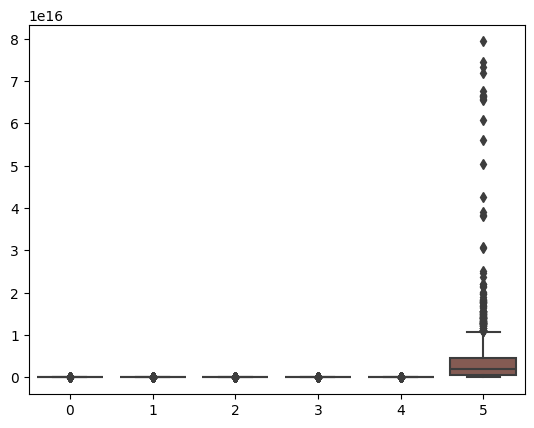

In [55]:
sns.boxplot(mean_prop_per_step)


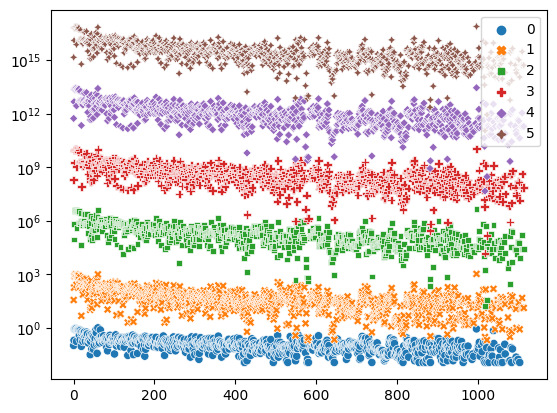

In [56]:
ax = sns.scatterplot(mean_prop_per_step)
ax.set_yscale("log")


<Axes: >

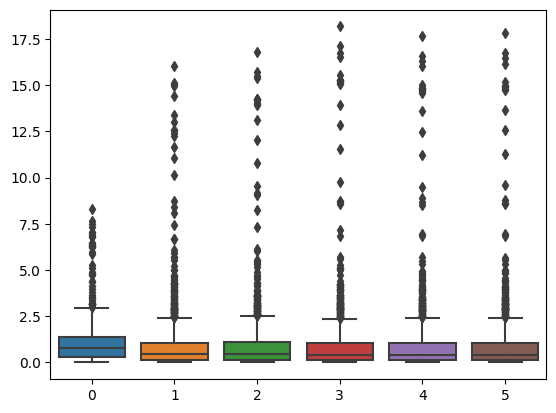

In [57]:
sns.boxplot(mean_prop_per_step /
            mean_prop_per_step.mean(axis=0, keepdims=True))


#### Normalized Propagation


In [ ]:
al_adj_inorm = np.sum(al_adj, axis=0)
al_adj_inorm[al_adj_inorm == 0] = 1
al_adj_inorm = al_adj / al_adj_inorm

al.edges["syn_inorm"] = al.edges.syn_count / al.edges.groupby(
    "post_pt_root_id"
).syn_count.transform("sum")


In [58]:
al_inorm_prop = dot_product_prop(al_sensory_imat, al_adj_inorm)
al_inorm_prop.shape


(1117, 1690, 6)

In [59]:
mean_prop_per_step = al_inorm_prop[:, al_alpn_idx, :].mean(axis=1)
mean_prop_per_step.shape


(1117, 6)

<Axes: >

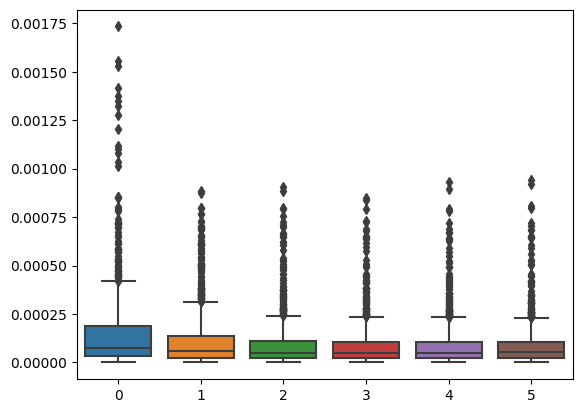

In [60]:
sns.boxplot(mean_prop_per_step)


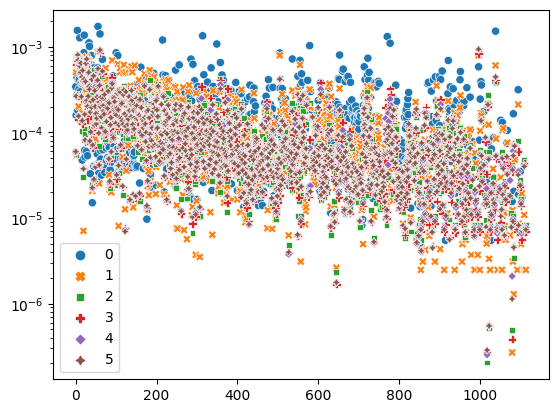

In [61]:
ax = sns.scatterplot(mean_prop_per_step)
ax.set_yscale("log")


<Axes: >

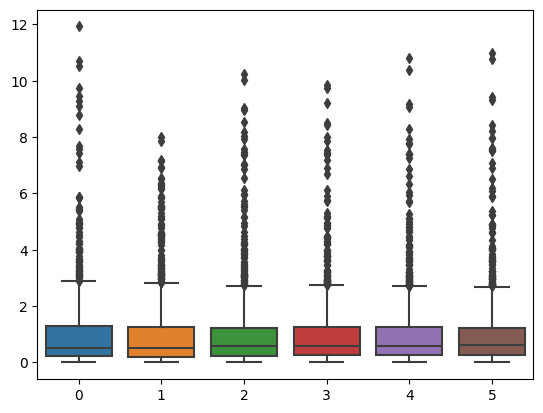

In [62]:
sns.boxplot(mean_prop_per_step /
            mean_prop_per_step.mean(axis=0, keepdims=True))


Text(135.64164925892777, 0.5, 'Sensory')

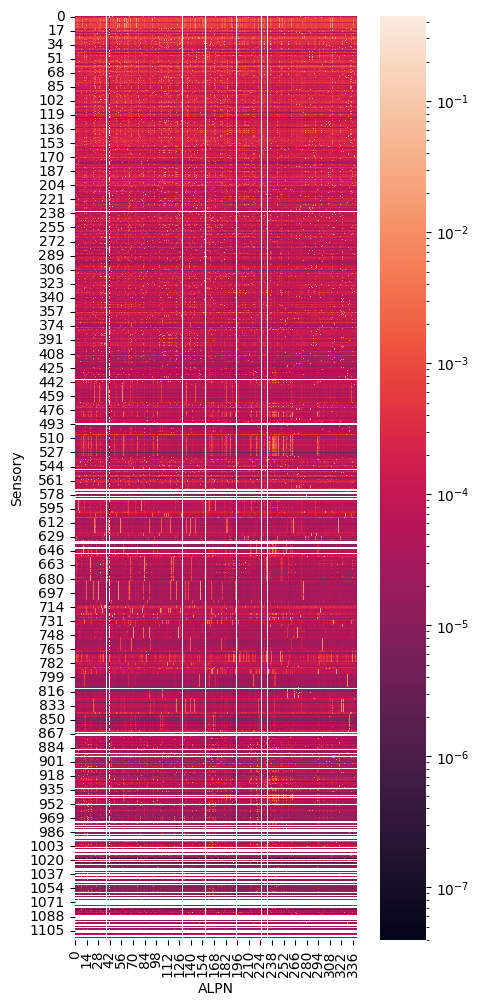

In [63]:
from matplotlib.colors import LogNorm

al_sensory_strongest_indirect_alpn = al_inorm_prop[:, al_alpn_idx, :].max(
    axis=2)
fig, ax = plt.subplots(figsize=(6, 12))
ax = sns.heatmap(al_sensory_strongest_indirect_alpn,
                 ax=ax, square=True, norm=LogNorm())
ax.set_xlabel("ALPN")
ax.set_ylabel("Sensory")


/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/championa/.pyenv/versions/3.11.3/envs/cajal2023/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


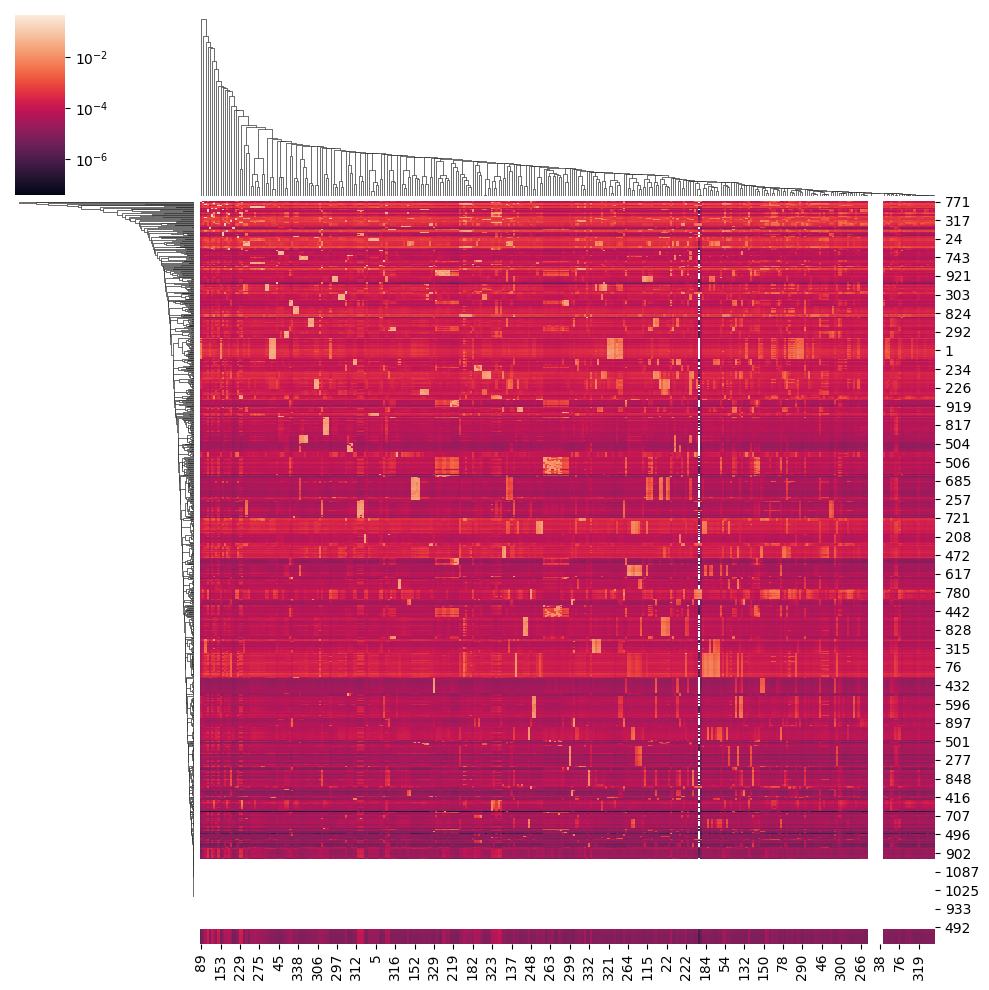

In [64]:
sns.clustermap(al_sensory_strongest_indirect_alpn, square=True, norm=LogNorm())


### Probabilistic Traversal


In [70]:
import os

from navis.models import TraversalModel


mod = TraversalModel(
    edges=al.edges.rename(
        columns={"pre_pt_root_id": "source", "post_pt_root_id": "target"}
    ),
    seeds=al.annot.loc[al_sensory_ind].index.values,
    weights="syn_inorm",
    max_steps=15,
)

mod.run(iterations=100)

  0%|          | 0/100 [00:00<?, ?it/s]

,steps,node
0,1,720575940603430112
1,1,720575940603659488
2,1,720575940603871404
3,1,720575940603911340
4,1,720575940604352689
...,...,...
159595,5,720575940642936576
159596,5,720575940645532288
159597,6,720575940622193280
159598,6,720575940628303616


In [71]:
layers = mod.summary
# layers = mod.summary
layers.head()


,node,layer_min,layer_max,layer_mean,layer_median
0,720575940603231872,2,4,2.3,2.0
1,720575940603430112,1,1,1.0,1.0
2,720575940603659488,1,1,1.0,1.0
3,720575940603871404,1,1,1.0,1.0
4,720575940603911340,1,1,1.0,1.0


In [72]:
layers = pd.merge(layers.set_index("node"), al.annot, left_index=True, right_index=True)

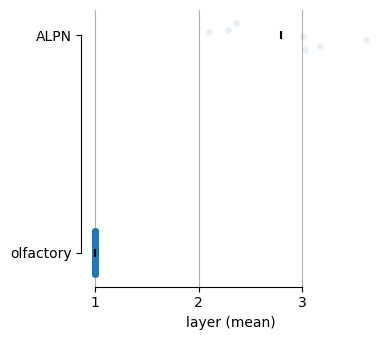

In [75]:
fig, ax = plt.subplots(figsize=(4, 3.5))

order = sorted(layers.cell_class.unique())

ax = sns.stripplot(
    data=layers, y="cell_class", x="layer_mean", alpha=0.1, order=order, ax=ax
)

x = layers.groupby("cell_class")["layer_mean"].mean().loc[order]
y = np.arange(0, len(order))

ax.scatter(x, y, marker="|", c="k", zorder=100)

ax.set_xlabel("layer (mean)")
ax.set_ylabel("")

ax.set_xticks(np.arange(1, np.ceil(layers.layer_mean.max())))

ax.grid(True, axis="x", which="both")

sns.despine(trim=True)

plt.tight_layout()


## Further Topics


- Comparative Indirect Connectivity
- More Non-linear Information Propagation
- Flows
